## Plot difference between 2 30yr means of zonal mean zonal wind in :
####   the "ssp585" experiment and the "historical" simulation
####   in all CMIP6 models containing both above simulations
####   for selected season (DJF) and over selected latitude range (0-90)

##### Created as part of PAMIP group during CMIP6 hackathon 2021
##### Created by : Phoebe Hudson / Colin Manning



In [1]:
from itertools import chain
from itertools import islice
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import re

# Set some plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

#!jupyter nbconvert --to script lpsd_scenariomip_ua_multimodel_pah.ipynb

In [3]:
### Set data directory where data structure follows 
#     /badc/cmip6/data/<mip_era>/<activity_id>/<institution_id>/<source_id>/<experiment_id>/<variant_label>/<table_id>/<variable_id>/<grid_label>/<version>
#   and experiment id follows
#     r = realization, i = initialization, p = physics, f = forcing

data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/*/ssp585/*/Amon/ua/gn/latest"

#!ls {data_dir}
data_in_dir_paths = glob(data_dir)
#data_in_dir_paths

In [11]:
f0 = glob(data_in_dir_paths[0]+'/*')
ds0 = xr.open_dataset(f0[0])
ds0

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, plev: 19, time: 1032)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    ua         (time, plev, lat, lon) float32 ...
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    title:                     TaiESM1 output prepared for CMIP6
    variable_id:               ua
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/bb6fb6d8-a443-4e49-8de8-a7f3a8a613cb

In [3]:
# View 2m temperature files (tas)

#data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/*/ssp585/*/Amon/tas/gn/latest"
#!ls {data_dir}

In [6]:
### Extract ensemble member name from pathname in an element (the 0th) of the data_in_dir_paths list 

#data_in_dir_paths[0].split(sep='/')[9]

'r1i1p1f1'

In [4]:
### Create dictionary of historical model names (element 7) and associated ensemble members (element 9)

hist_model_data_dir = "/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/ua/gn/latest/"
hist_data_in_dir_paths = glob(hist_model_data_dir)
hist_models = {}
for i in range(0,len(hist_data_in_dir_paths)):
    model_name = hist_data_in_dir_paths[i].split(sep='/')[7]
    if model_name not in hist_models:
        hist_models[model_name] = [hist_data_in_dir_paths[i].split(sep='/')[9]] # assign member to list
    else:
        hist_models[model_name].append(hist_data_in_dir_paths[i].split(sep='/')[9])
        
#hist_models

In [5]:
### Create dictionary of ssp585 model names (element 7) and associated ensemble members (element 9)

models = {}
for i in range(0,len(data_in_dir_paths)):
    model_name = data_in_dir_paths[i].split(sep='/')[7]
    if model_name not in models:
        models[model_name] = [data_in_dir_paths[i].split(sep='/')[9]] # assign member to list
    else:
        models[model_name].append(data_in_dir_paths[i].split(sep='/')[9])
        
#islice(models, 16)

In [6]:
### Create list of 30 yr differences in zonal mean zonal wind for each model in dictionary "models"

# Calculate zonal mean of zonal wind (mean over all longitudes) and sub-select by latitude (N hem = 0,90)
# Select winter months (DJF=Dec-Feb) from zonal mean zonal wind
# Calculate difference between two 30-yr means of zonal mean zonal winds for
#     the "historical" simulation : over 1850-01-16 - 1880-12-16 and 
#     the "ssp585" experiment : over 1969-01-16 - 1999-12-16

ds_all_models_list = []
for model in islice(models,29):
    i=0
    print(model)
    for member in (models[model]):
        #print(model)
        forc_model_data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/"+ str(model)+'/ssp585/'+str(member)+'/Amon/ua/gn/latest/*'
        hist_model_data_dir = "/badc/cmip6/data/CMIP6/CMIP/*/"+ str(model)+'/historical/'+str(member)+'/Amon/ua/gn/latest/*'
        forc_model_data_in_dir_paths = glob(forc_model_data_dir)
        hist_model_data_in_dir_paths = glob(hist_model_data_dir)
        #Check files exist for this model in both historical and ssp585 experiment
        if (len(forc_model_data_in_dir_paths)>0) & (len(hist_model_data_in_dir_paths))>0 :
            hist_endtime = str(hist_model_data_in_dir_paths[-1])[-9:-3]
            forc_starttime = str(forc_model_data_in_dir_paths[0])[-16:-10]
            #Check start time of ssp585 experiment is after end time of historical experiment
            if hist_endtime>forc_starttime :
                model_data_in_dir_paths_all = forc_model_data_in_dir_paths + hist_model_data_in_dir_paths[:-1]
            else :
                model_data_in_dir_paths_all = forc_model_data_in_dir_paths + hist_model_data_in_dir_paths
            #print(len(model_data_in_dir_paths_all))
            ds_n = xr.open_mfdataset(model_data_in_dir_paths_all)
            #print(ds_n)
            #Check end time of spp585 experiment is later than final year in time slice (2099)
            if int(str(ds_n.time[-1].values)[0:4]) >= 2099 :
                #Change name of variable latitude to lat in the 1 model that calls it latitude/longitude
                try : 
                    ds_n = ds_n.rename({'latitude':'lat', 'longitude':'lon'})
                except ValueError : 
                    pass
                ds_n = ds_n.mean(dim='lon').sel(lat=slice(0, 90))
                is_winter = ds_n['time'].dt.season == 'DJF'
                ds_n_winter = ds_n.isel(time=is_winter)
                ds_n_endyrs = ds_n_winter.sel(time=slice('2069-01-16', '2099-12-16')).mean(dim='time')
                ds_n_startyrs = ds_n_winter.sel(time=slice('1850-01-16', '1880-12-16')).mean(dim='time')
                ds_n_yrsdiff = ds_n_endyrs - ds_n_startyrs
                if i==0 : 
                    ds_t = ds_n_yrsdiff
                if i>0 : 
                    ds_t = ds_t + ds_n_yrsdiff
                i+=1
    ds_t = ds_t/i
    ds_t['plev'] = ds_t.plev.values/100
    ds_all_models_list.append(ds_t)

    ### Alternative to a list is to write out datasets (ds_t) to netcdf 
    #      datasets as a list makes the above script quicker BUT takes longer to plot (below)
    #      datasets saved as netcdf files is quicker to plot BUT it takes longer to create the files
    #   If you want to create netcdf files - look at Colin's script + submit a LOTUS batch job
    
    #ds_t.to_netcdf('/gws/pw/j05/cop26_hackathons/bristol/project05/cmip6_zonal_ensemble_mean/'+str(model)+'_ensmean_DJF_zonal_mean_ua_Amon_diff_2069-2099_1850-1880.nc')
    #ds_t.to_netcdf('/home/users/phohud/pah_phd_scripts/cmip6_hack/cmip6_zonal_ensmean/'+str(model)+'_ensmean_DJF_zonal_mean_ua_Amon_diff_2069-2099_1850-1880.nc')
    
    

TaiESM1


KeyboardInterrupt: 

In [14]:
### Turn the dictionary (models) into a list of model names

models_list = list(models.keys())
#ds_all_models_list[i]
len(models_list)

29

In [ ]:
### Plot the difference in 30 yr mean zonal mean zonal wind for the first nplot**2 models (16) and save fig
#     NOTE : This failed every time I tried to run it in the jasmin jupyter notebook environment (kernel died)
#     I suggest you convert this notebook to a python file and run that from the command line

cmap = plt.get_cmap('RdBu_r')

nplots = 4

fig, axes = plt.subplots(nrows=nplots, ncols=nplots) #, figsize=(15,15))
for i in range(0,nplots**2): #len(ds_all_models_list))
    print(models_list[i])
    ds_i = ds_all_models_list[i]
    ax = plt.subplot(nplots,nplots,i+1)
    plt.contourf(ds_i.lat, ds_i.plev, ds_i.ua.values, cmap='RdBu_r', levels=np.arange(-1,1,0.1), extend='both')
    #plt.pcolormesh(ds_lonmean.lat, ds_lonmean.plev, ds_lonmean_yrsdiff.ua.values, cmap='RdBu_r')
    plt.xlabel('Lat')
    plt.ylabel('Pressure Level (hPa)')
    plt.ylim([1000, 100]) #[100000, 10000])
    plt.title(str(models_list[i]))
    #axs=np.append(axs,ax)

    normalize=matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cax, _ = matplotlib.colorbar.make_axes(ax, location = "bottom", pad=0.05)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,orientation="horizontal")
    #cbar.set_label('Zonal windspeed ',size=16)
    cbar.ax.tick_params(labelsize=16)
plt.show()
figdir = '/home/users/phohud/pah_phd_scripts/cmip6_hack/project05/results/'
fig.savefig((figdir+'cmip6_'+str(int(nplots**2))+'model_zonal_mean_diff_scen585_2069-2099_hist_1850-1880.png'), dpi=100, transparent=False, bbox_inches='tight', pad_inches=0.1)


/gws/pw/j05/cop26_hackathons/bristol/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


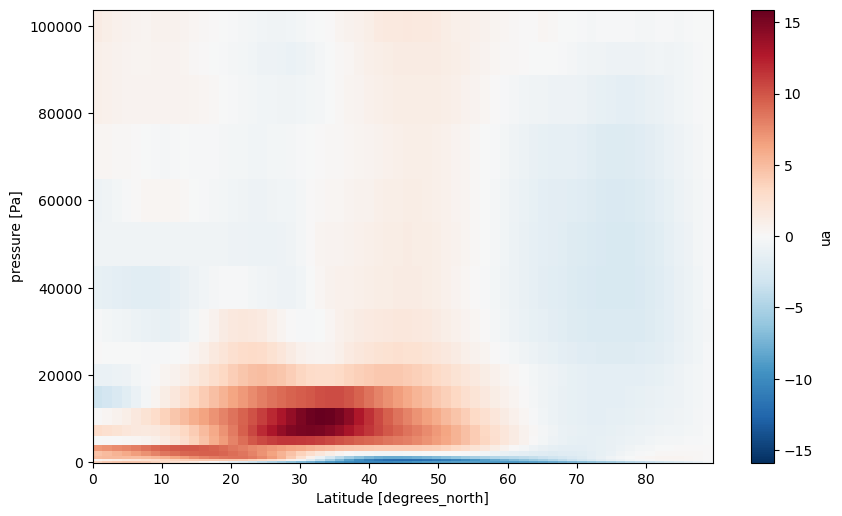

In [12]:
### Plot the zonal mean zonal wind 30 yr diff in the last dataset loaded in above

ds_t.ua.plot()